# Customer Segmentation Using GMM

## Description:
In this project, we will implement a Gaussian Mixture Model (GMM) from scratch and use it to perform customer segmentation based on demographic and behavioral data. Customer segmentation is the process of grouping customers into clusters such that customers within the same cluster are more similar to each other than to those in other clusters. In this project, segmentation is done using a probabilistic clustering approach, where each customer is assigned a probability of belonging to each cluster based on features such as Age, Annual Income, and Spending Score.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

In [3]:
df = pd.read_csv(r"Mall_Customers.csv")
df.head(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [4]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

def standard_scale(X):

    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_scaled = (X - means) / stds

    return X_scaled, means, stds

X_scaled, means_X, stds_X = standard_scale(X)


In [5]:
def gaussian_pdf_all(X, mean, cov):
    n_samples, n_features = X.shape
    try:
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        reg_cov = cov + np.eye(n_features) * 1e-6
        det = np.linalg.det(reg_cov)
        inv = np.linalg.inv(reg_cov)

    norm_const = -0.5 * (n_features * np.log(2 * np.pi) + np.log(det + 1e-10))

    X_mu = X - mean
    exponent = -0.5 * np.sum(np.dot(X_mu, inv) * X_mu, axis=1)

    return np.exp(norm_const + exponent)

def initialize_parameters(X, k, rng):

    n_samples, n_features = X.shape

    weights = np.ones(k) / k

    indices = rng.choice(n_samples, k, replace=False)
    means = X[indices]

    covs = np.array([np.eye(n_features) for _ in range(k)])

    return weights, means, covs

def expectation_step(X, weights, means, covs):
    n_samples = X.shape[0]
    k = len(weights)
    resp = np.zeros((n_samples, k))

    for i in range(k):
        resp[:, i] = weights[i] * gaussian_pdf_all(X, means[i], covs[i])

    sum_resp = resp.sum(axis=1, keepdims=True)

    sum_resp[sum_resp == 0] = 1e-10

    resp = resp / sum_resp
    return resp

def maximization_step(X, resp):
    n_samples, n_features = X.shape
    k = resp.shape[1]

    nk = resp.sum(axis=0)

    weights = nk / n_samples

    means = np.dot(resp.T, X) / nk[:, np.newaxis]

    covs = np.zeros((k, n_features, n_features))
    for i in range(k):
        diff = X - means[i]
        covs[i] = np.dot(resp[:, i] * diff.T, diff) / nk[i]

        covs[i] += np.eye(n_features) * 1e-6
    return weights, means, covs

def compute_log_likelihood(X, weights, means, covs):
    n_samples = X.shape[0]
    k = len(weights)

    probs = np.zeros((n_samples, k))
    for i in range(k):
        probs[:, i] = weights[i] * gaussian_pdf_all(X, means[i], covs[i])

    total_probs = probs.sum(axis=1)
    total_probs[total_probs == 0] = 1e-10

    ll = np.sum(np.log(total_probs))
    return ll

def gmm_train(X, k, max_iter=200, tol=1e-4, seed=None):
    rng = np.random.default_rng(seed)

    weights, means, covs = initialize_parameters(X, k, rng)
    prev_ll = -np.inf

    final_resp = None
    final_ll = None

    for i in range(max_iter):
        resp = expectation_step(X, weights, means, covs)

        weights, means, covs = maximization_step(X, resp)

        ll = compute_log_likelihood(X, weights, means, covs)

        if np.abs(ll - prev_ll) < tol:
            break

        prev_ll = ll
        final_resp = resp
        final_ll = ll

    return weights, means, covs, resp, ll

In [6]:
def compute_bic(ll, k, n, d):
    num_params = k * d + k * d * (d + 1) / 2 + (k - 1)
    return -2*ll + num_params * np.log(n)

bic_values = []
k_range = range(2,9)
best_models = []

n, d = X_scaled.shape

for k in k_range:
    best_ll_k = -np.inf
    best_run_results = None

    for i in range(10):
        try:
            weights, means, covs, resp, ll = gmm_train(X_scaled, k, seed=i)
            if ll > best_ll_k:
                best_ll_k = ll
                best_run_results = (weights, means, covs, resp, ll)
        except Exception:
            continue

    if best_run_results is not None:
        bic = compute_bic(best_ll_k, k, n, d)
        bic_values.append(bic)
        best_models.append(best_run_results)
    else:
        bic_values.append(np.inf)
        best_models.append(None)

best_k_idx = np.argmin(bic_values)
best_k = k_range[best_k_idx]

print("BIC values per K:", np.round(bic_values, 2))
print("\nBest k =", best_k)


BIC values per K: [1656.16 1612.1  1576.18 1575.91 1598.03 1629.25 1649.33]

Best k = 5


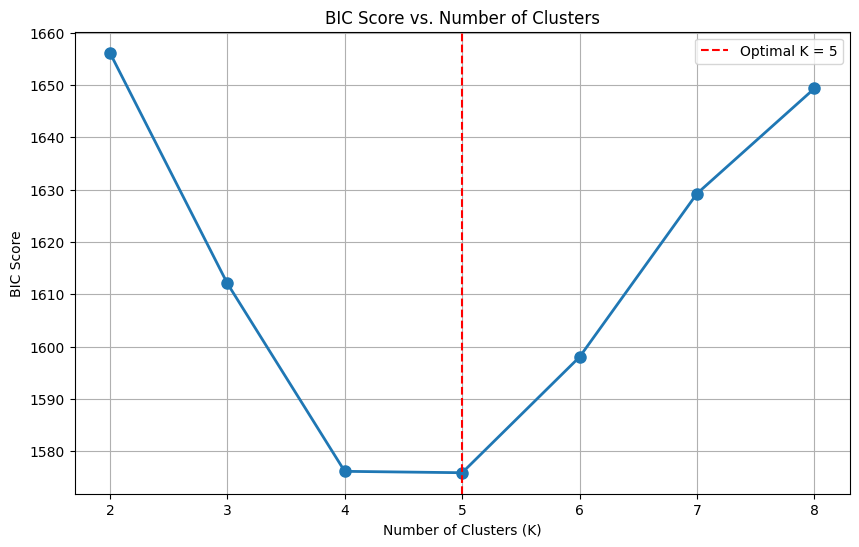

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, bic_values, marker='o', linewidth=2, markersize=8)
plt.title('BIC Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('BIC Score')
plt.grid(True)
plt.xticks(k_range)

plt.axvline(x=best_k, color='r', linestyle='--', label=f'Optimal K = {best_k}')
plt.legend()
plt.show()

In [8]:
best_ll_final = -np.inf
best_weights = None
best_means = None
best_covs = None
best_resp = None

print(f"Training final model with K={best_k}...")

for i in range(10):
    try:
        w, m, c, r, ll = gmm_train(X_scaled, best_k, seed=i)

        if ll > best_ll_final:
            best_ll_final = ll
            best_weights = w
            best_means = m
            best_covs = c
            best_resp = r
    except Exception:
        continue

print(f"Final Log Likelihood: {best_ll_final:.4f}")
print("Model training complete.")

Training final model with K=5...
Final Log Likelihood: -658.1469
Model training complete.


C:\Users\UOK\AppData\Local\Temp\ipykernel_1664\3391999465.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', k)


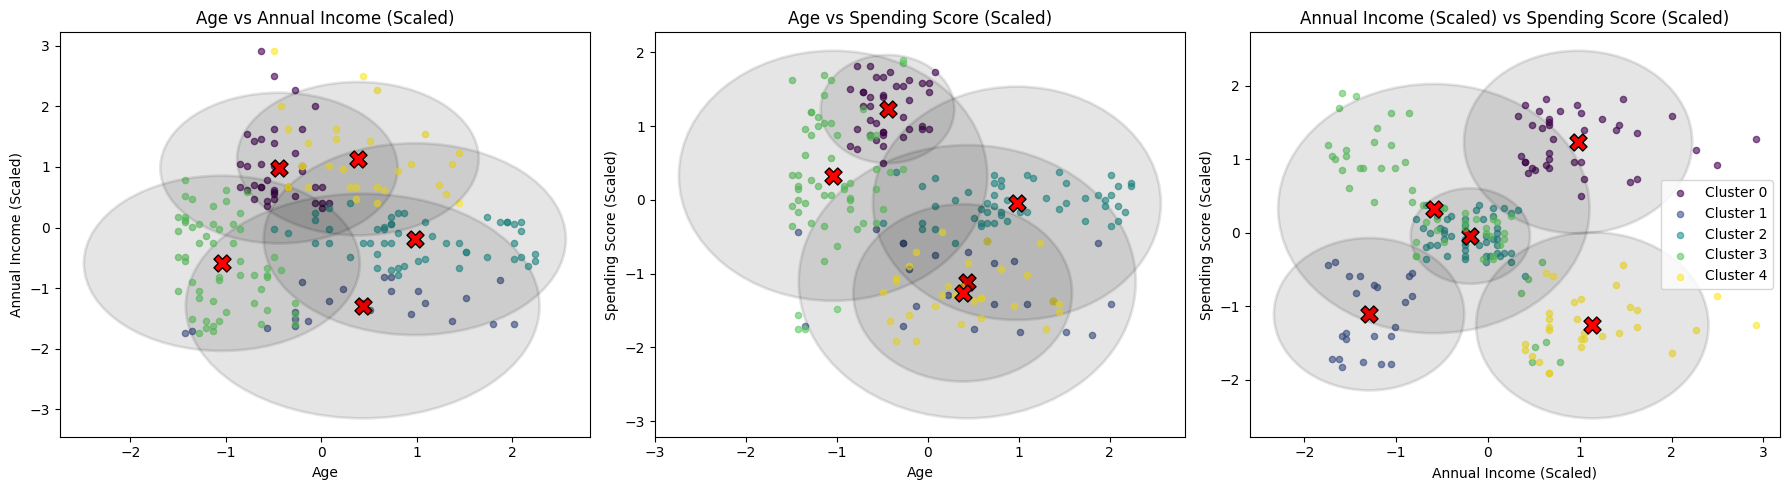

In [9]:
def plot_2d_clusters(X, resp, means, covs, feature_names):
    labels = np.argmax(resp, axis=1)
    k = len(means)

    pairs = [(0, 1), (0, 2), (1, 2)]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = plt.cm.get_cmap('viridis', k)

    for idx, (f1, f2) in enumerate(pairs):
        ax = axes[idx]

        for cluster in range(k):
            mask = labels == cluster
            color = colors(cluster)

            ax.scatter(X[mask, f1], X[mask, f2], s=20, color=color, alpha=0.6, label=f'Cluster {cluster}')

            mean_2d = means[cluster][[f1, f2]]
            cov_2d = covs[cluster][[f1, f2]][:, [f1, f2]]

            radius = 2 * np.sqrt(np.max(np.diag(cov_2d)))

            circle = Circle(xy=mean_2d, radius=radius, alpha=0.1, color='black', linewidth=2, fill=True)
            ax.add_patch(circle)

            ax.scatter(mean_2d[0], mean_2d[1], s=150, color='red', marker='X', edgecolors='black')

        ax.set_xlabel(feature_names[f1])
        ax.set_ylabel(feature_names[f2])
        ax.set_title(f'{feature_names[f1]} vs {feature_names[f2]}')
        if idx == 2:
            ax.legend()

    plt.tight_layout()
    plt.show()

feature_names = ['Age', 'Annual Income (Scaled)', 'Spending Score (Scaled)']

plot_2d_clusters(X_scaled, best_resp, best_means, best_covs, feature_names)

C:\Users\UOK\AppData\Local\Temp\ipykernel_1664\3409099605.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', k)


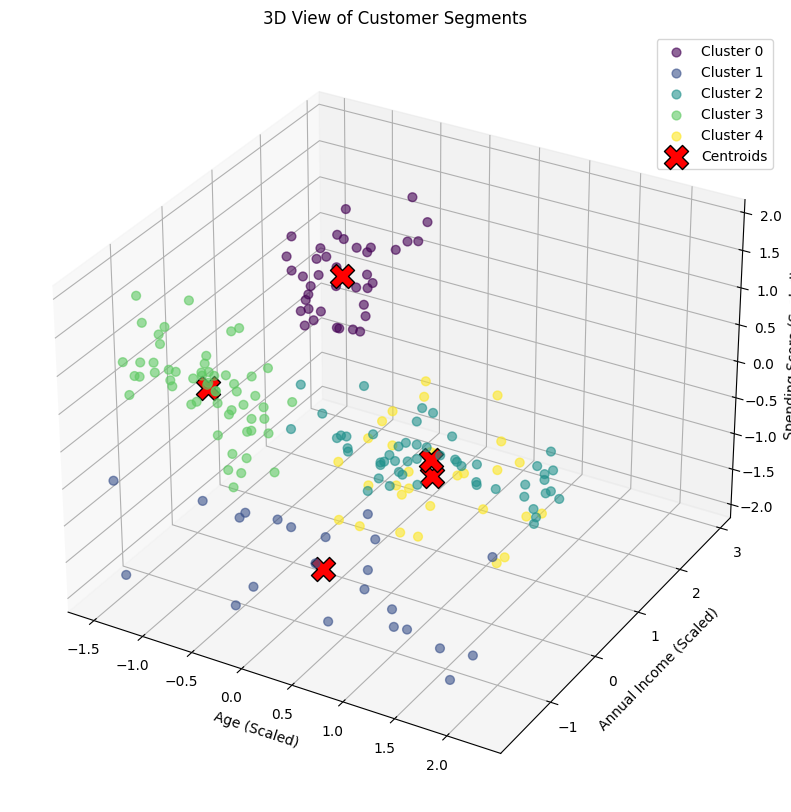

In [10]:
def plot_3d_clusters(X, resp, means, feature_names):
    labels = np.argmax(resp, axis=1)
    k = len(means)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    colors = plt.cm.get_cmap('viridis', k)

    for cluster in range(k):
        mask = labels == cluster
        ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2],
                   color=colors(cluster), label=f'Cluster {cluster}', s=40, alpha=0.6)

    ax.scatter(means[:, 0], means[:, 1], means[:, 2],
               color='red', marker='X', s=300, label='Centroids', depthshade=False, edgecolors='black')

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.set_title('3D View of Customer Segments')
    ax.legend()

    plt.show()

feature_names = ['Age (Scaled)', 'Annual Income (Scaled)', 'Spending Score (Scaled)']

plot_3d_clusters(X_scaled, best_resp, best_means, feature_names)

In [11]:
labels = np.argmax(best_resp, axis=1)

df['Cluster'] = labels

output_filename = 'Mall_Customers_Segmented.csv'
df.to_csv(output_filename, index=False)

print(f"Segmented data saved to {output_filename}")
print(df.head())

Segmented data saved to Mall_Customers_Segmented.csv
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)   
0           1    Male   19                  15                      39  \
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster  
0        1  
1        3  
2        1  
3        3  
4        1  


In [12]:
df.head(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,1
1,2,Male,21,15,81,3
2,3,Female,20,16,6,1
3,4,Female,23,16,77,3
4,5,Female,31,17,40,1
5,6,Female,22,17,76,3
6,7,Female,35,18,6,1
7,8,Female,23,18,94,3
8,9,Male,64,19,3,1
9,10,Female,30,19,72,3
